#Data Insights1-which attribute is related to price?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D      # noqa: F401 (enables 3-D)
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans


In [2]:
# Load your cleaned file
df = pd.read_csv("clean_car_data.csv")

# ---- OPTIONAL: subsample very large files to speed things up ----
if len(df) > 10_000:
    df = df.sample(10_000, random_state=42).reset_index(drop=True)


In [3]:
y = df["price"]
X = df.drop(columns=["price"])      # every other column is a predictor

numeric_cols     = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object",  "category"]).columns.tolist()


In [4]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ],
    remainder="passthrough"    # leaves numeric columns untouched
)

rf_pipe = Pipeline(
    steps=[
        ("pre", preprocessor),
        ("rf",  RandomForestRegressor(
                    n_estimators=120,        # keep small for faster run-time
                    random_state=42,
                    n_jobs=-1))
    ]
)


In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42
)

rf_pipe.fit(X_train, y_train)


Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'dealer_name',
                                                   'company', 'model', 'engine',
                                                   'transmission', 'color',
                                                   'dealer_no', 'body_style',
                                                   'dealer_region', 'sale_date',
                                                   'sale_month',
                                                   'sale_quarter'])])),
                ('rf',
                 RandomForestRegressor(n_estimators=120, n_jobs=-1,
                                       random_state=42))])

In [6]:
perm = permutation_importance(
    rf_pipe, X_val, y_val,
    n_repeats=5, random_state=42, n_jobs=-1
)

feature_names = rf_pipe.named_steps["pre"].get_feature_names_out()
importances   = perm.importances_mean
order         = np.argsort(importances)[::-1]

top_table = (
    pd.DataFrame({"feature": feature_names[order],
                  "importance": importances[order]})
      .reset_index(drop=True)
)
print("\nTop 10 predictors of price:\n", top_table.head(10))



Top 10 predictors of price:
                                              feature  importance
0                       cat__dealer_name_Capitol KIA    0.822741
1                     cat__dealer_name_Classic Chevy    0.613389
2                  cat__dealer_name_C & M Motors Inc    0.180556
3                 cat__dealer_name_Chrysler Plymouth    0.118574
4            cat__dealer_name_Chrysler of Tri-Cities    0.096077
5                cat__dealer_name_Diehl Motor CO Inc    0.035679
6                   cat__dealer_name_Iceberg Rentals    0.004267
7        cat__dealer_name_Gartner Buick Hyundai Saab    0.002116
8             cat__dealer_name_Enterprise Rent A Car    0.000666
9  cat__dealer_name_Buddy Storbeck's Diesel Servi...    0.000358


In [8]:
top3_idx   = order[:3]
top3_names = feature_names[top3_idx]

# Transform the *entire* feature matrix to one-hot space
X_enc = rf_pipe.named_steps["pre"].transform(X)
if not isinstance(X_enc, np.ndarray):
    X_enc = X_enc.toarray()

X_top3 = X_enc[:, top3_idx]        # shape (n_samples, 3)


In [9]:
kmeans   = KMeans(n_clusters=3, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(X_top3)


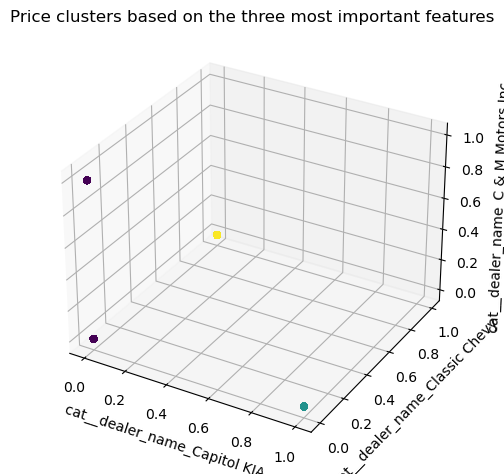

In [10]:
fig = plt.figure()
ax  = fig.add_subplot(111, projection="3d")

ax.scatter(X_top3[:, 0], X_top3[:, 1], X_top3[:, 2], c=clusters)
ax.set_xlabel(top3_names[0])
ax.set_ylabel(top3_names[1])
ax.set_zlabel(top3_names[2])
ax.set_title("Price clusters based on the three most important features")

plt.tight_layout()
plt.show()


In [12]:
# -------------------------------------------------------------
# 0. Imports
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D          # noqa: F401  (enables 3-D)
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans

# -------------------------------------------------------------
# 1. Load data  +  drop dealer_name / dealer_no
# -------------------------------------------------------------
df = pd.read_csv("clean_car_data.csv")           # <-- adjust path if needed

cols_to_remove = [c for c in ["dealer_name", "dealer_no"] if c in df.columns]
df = df.drop(columns=cols_to_remove)

# -------------------------------------------------------------
# 2. Define target and predictors
# -------------------------------------------------------------
y = df["price"]
X = df.drop(columns=["price"])

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

preprocess = ColumnTransformer(
    [("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
    remainder="passthrough"                       # keeps numeric columns
)

rf_pipe = Pipeline([
    ("pre", preprocess),
    ("rf",  RandomForestRegressor(
                n_estimators=120,                 # make larger once things run
                random_state=42,
                n_jobs=-1))
])

# -------------------------------------------------------------
# 3. Train / validation split and fit
# -------------------------------------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42
)
rf_pipe.fit(X_train, y_train)

# -------------------------------------------------------------
# 4. Permutation feature importance  ➜  aggregate to attributes
# -------------------------------------------------------------
perm = permutation_importance(
    rf_pipe, X_val, y_val,
    n_repeats=5, random_state=42, n_jobs=-1
)

feat_names   = rf_pipe.named_steps["pre"].get_feature_names_out()
feat_scores  = perm.importances_mean

def original_attr(encoded_name: str) -> str:
    """
    Map a one-hot column back to the source attribute.
    e.g. 'cat__body_style_SUV'  -> 'body_style'
    """
    if encoded_name.startswith("cat__"):
        return encoded_name.split("cat__")[1].split("_")[0]
    # numeric passthrough columns look like 'remainder__annual_income'
    if encoded_name.startswith("remainder__"):
        return encoded_name.split("remainder__")[1]
    return encoded_name

attr_scores = {}
for name, sc in zip(feat_names, feat_scores):
    base = original_attr(name)
    attr_scores[base] = attr_scores.get(base, 0.0) + sc

attr_series = (pd.Series(attr_scores)
                 .sort_values(ascending=False)
                 .rename("importance"))

print("\nTop-10 attributes most related to price:\n")
print(attr_series.head(10).to_string())

# -------------------------------------------------------------
# 5. Pick the three strongest attributes
# -------------------------------------------------------------
top3_attrs = attr_series.head(3).index.tolist()
print("\nTop-3 attributes:", top3_attrs)

# Indices of encoded columns belonging to any of those attributes
top3_encoded_idx = [
    i for i, col in enumerate(feat_names)
    if original_attr(col) in top3_attrs
]


Top-10 attributes most related to price:

company    2.302862
gender    -0.000495

Top-3 attributes: ['company', 'gender']


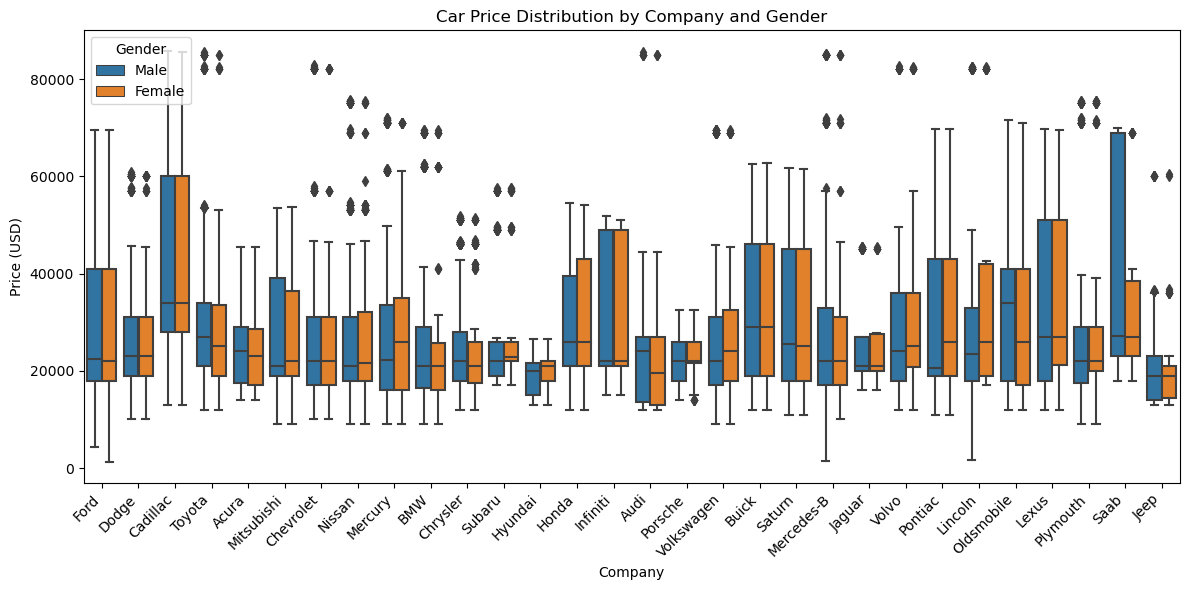

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="company", y="price", hue="gender")
plt.xticks(rotation=45, ha='right')
plt.title("Car Price Distribution by Company and Gender")
plt.xlabel("Company")
plt.ylabel("Price (USD)")
plt.legend(title="Gender")
plt.tight_layout()
plt.show()


#predict the car fit you best

In [17]:
# 0. Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [23]:
# 1-a. Define X and Y
X = df[["annual_income", "price", "gender"]].copy()
y_raw = df[["company", "model", "engine", "transmission", "body_style"]].copy()


# 1-b. Label-encode each target column
from sklearn.preprocessing import LabelEncoder
y_enc = pd.DataFrame()
label_encoders = {}
for col in y_raw.columns:
    le = LabelEncoder()
    y_enc[col] = le.fit_transform(y_raw[col])
    label_encoders[col] = le


In [25]:

pre = ColumnTransformer(
    [("num", StandardScaler(), ["annual_income", "price"]),
     ("cat", OneHotEncoder(drop="if_binary"), ["gender"])]
)

rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
pipe = Pipeline([("pre", pre), ("clf", MultiOutputClassifier(rf))])



In [26]:
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y_enc, test_size=0.20, random_state=42, stratify=y_enc["body_style"]
)
pipe.fit(X_tr, y_tr)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['annual_income', 'price']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['gender'])])),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=300,
                                                                        n_jobs=-1,
                                                                        random_state=42)))])

In [27]:
from sklearn.metrics import accuracy_score
y_pred = pipe.predict(X_te)
for i, col in enumerate(y_enc.columns):
    print(f"{col:12}: {accuracy_score(y_te[col], y_pred[:, i]):.2%}")

company     : 14.09%
model       : 9.87%
engine      : 65.58%
transmission: 65.58%
body_style  : 27.14%


In [ ]:
# PREDICT FOR SAMPLE  (Female, 100 000 income, 20 000 price)
sample = pd.DataFrame({"annual_income": [100000],
                       "price":         [20000],
                       "gender":        ["Female"]})

pred_enc = pipe.predict(sample)[0]
pred_human = {col: label_encoders[col].inverse_transform([pred_enc[i]])[0]
              for i, col in enumerate(y_enc.columns)}

print("\nPrediction for Female | income 100k | price 20k:\n", pred_human)



Prediction for Female | income 100k | price 20k:
 {'company': 'Chevrolet', 'model': 'Cavalier', 'engine': 'Overhead Camshaft', 'transmission': 'Manual', 'body_style': 'SUV'}


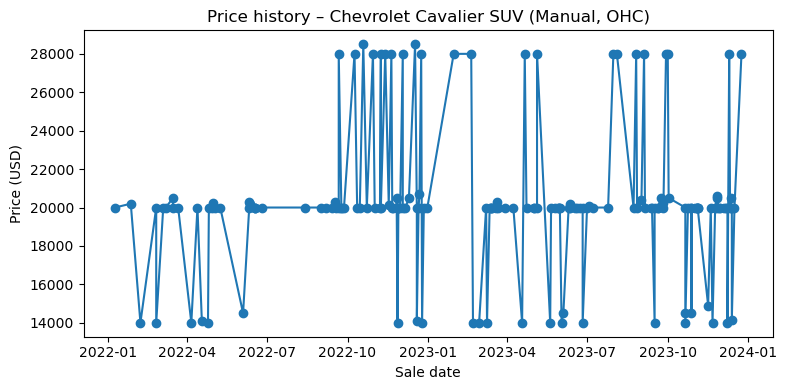

Requested region : Worcester
Region used      : Austin
Lowest price     : $14,000
Colour           : Pale White


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# 1. Load data  (adjust the path if needed)
# -------------------------------------------------------------
df = pd.read_csv("clean_car_data.csv")

# -------------------------------------------------------------
# 2. Focus ONLY on the requested specification
# -------------------------------------------------------------
SPEC = {
    "company":      "Chevrolet",
    "model":        "Cavalier",
    "engine":       "Overhead Camshaft",
    "transmission": "Manual",
    "body_style":   "SUV",
}

spec_df = df.copy()
for k, v in SPEC.items():
    spec_df = spec_df[spec_df[k] == v]

# -------------------------------------------------------------
# 3. Plot price-versus-sale-date for that spec
# -------------------------------------------------------------
if "sale_date" not in spec_df.columns:
    raise KeyError("Column 'sale_date' missing from dataset!")

spec_df["sale_date"] = pd.to_datetime(spec_df["sale_date"], errors="coerce")
spec_df = spec_df.dropna(subset=["sale_date"]).sort_values("sale_date")

plt.figure(figsize=(8, 4))
plt.plot(spec_df["sale_date"], spec_df["price"], marker="o")
plt.title("Price history – Chevrolet Cavalier SUV (Manual, OHC)")
plt.xlabel("Sale date")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4. Build lowest-price lookup *for this spec* by dealer region
# -------------------------------------------------------------
if spec_df.empty:
    raise ValueError("No rows match the requested car specification!")

idx_min = spec_df.groupby("dealer_region")["price"].idxmin()
region_min_spec = spec_df.loc[idx_min, ["dealer_region", "color", "price"]]

# Dictionaries for quick lookup
spec_rgn_to_price = dict(zip(region_min_spec["dealer_region"], region_min_spec["price"]))
spec_rgn_to_color = dict(zip(region_min_spec["dealer_region"], region_min_spec["color"]))

# Global fallback within this spec (cheapest Cavalier SUV overall)
g_idx          = spec_df["price"].idxmin()
global_price   = spec_df.loc[g_idx, "price"]
global_color   = spec_df.loc[g_idx, "color"]
global_region  = spec_df.loc[g_idx, "dealer_region"]

# -------------------------------------------------------------
# 5. Function → predict lowest price & colour for a region
# -------------------------------------------------------------
def predict_spec_lowest(region_name: str):
    """Return (price, color, region_used) for the spec’s cheapest
       listing in 'region_name' (case-insensitive).  Fall back to the
       global cheapest Cavalier SUV if region isn’t available."""
    norm = {r.lower(): r for r in spec_rgn_to_price.keys()}
    if region_name.lower() in norm:
        r = norm[region_name.lower()]
        return spec_rgn_to_price[r], spec_rgn_to_color[r], r
    else:
        return global_price, global_color, global_region




In [31]:
# ── 3. Pick the cheapest listing *in Austin*
if "Austin" in df["dealer_region"].values:
    row = df.loc[df[df["dealer_region"] == "Austin"]["price"].idxmin()]
    print("Method-1 (lookup)")
    print(f"Region   : {row['dealer_region']}")
    print(f"Price    : ${row['price']:,.0f}")
    print(f"Colour   : {row['color']}")
else:
    print("No Austin listings in the dataset – nothing to look up.")

Method-1 (lookup)
Region   : Austin
Price    : $9,000
Colour   : Black


In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier

# ───────────────────────────────────────────────────────────────
# 1. Load data
# ───────────────────────────────────────────────────────────────
df = pd.read_csv("clean_car_data.csv")

# ───────────────────────────────────────────────────────────────
# 2. Prepare features and targets
# ───────────────────────────────────────────────────────────────
X         = df[["dealer_region"]]
y_price   = df["price"]
y_colour  = df["color"]

pre = ColumnTransformer(
    [("ohe", OneHotEncoder(handle_unknown="ignore"), ["dealer_region"])],
    remainder="drop"
)

# ── Price regressor
price_pipe = Pipeline([
    ("pre", pre),
    ("gb",  GradientBoostingRegressor(random_state=42))
])
Xp_tr, Xp_te, yp_tr, yp_te = train_test_split(
    X, y_price, test_size=0.2, random_state=42
)
price_pipe.fit(Xp_tr, yp_tr)

# ── Colour classifier
colour_pipe = Pipeline([
    ("pre", pre),
    ("rf",  RandomForestClassifier(
            n_estimators=300, random_state=42, n_jobs=-1))
])
Xc_tr, Xc_te, yc_tr, yc_te = train_test_split(
    X, y_colour, test_size=0.2, random_state=42, stratify=y_colour
)
colour_pipe.fit(Xc_tr, yc_tr)

# ───────────────────────────────────────────────────────────────
# 3. Helper – must wrap the region in a DataFrame with a column
# ───────────────────────────────────────────────────────────────
def predict_price_and_colour(region: str):
    """
    Return (pred_price, pred_colour, seen_flag)
    If 'region' never appeared in training, models still work because
    OneHotEncoder(handle_unknown='ignore') creates zero-vector.
    """
    region_df = pd.DataFrame({"dealer_region": [region]})
    pred_price  = float(price_pipe.predict(region_df)[0])
    pred_colour = colour_pipe.predict(region_df)[0]
    # Determine if region was in training
    region_seen = region in Xp_tr["dealer_region"].unique()
    return pred_price, pred_colour, region_seen

# ───────────────────────────────────────────────────────────────
# 4. Example queries
# ───────────────────────────────────────────────────────────────
for region in ["Austin", "Worcester"]:
    price, colour, seen = predict_price_and_colour(region)
    if seen:
        print(f"{region}:  est. price = ${price:,.0f},  colour = {colour}")
    else:
        print(f"{region}:  unseen during training  →  est. price = ${price:,.0f}, colour = {colour}")


Austin:  est. price = $28,544,  colour = Pale White
Worcester:  unseen during training  →  est. price = $28,155, colour = Pale White


In [34]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    precision_recall_fscore_support,
)

# ───────────────────────────────────────────────────────────────
# 5. Price-model scores  (test set)
# ───────────────────────────────────────────────────────────────
y_price_pred = price_pipe.predict(Xp_te)

mae  = mean_absolute_error(yp_te, y_price_pred)
rmse = mean_squared_error(yp_te, y_price_pred, squared=False)
r2   = r2_score(yp_te, y_price_pred)

print("Price regression (dealer_region ➜ price)")
print(f"  MAE   : ${mae:,.0f}")
print(f"  RMSE  : ${rmse:,.0f}")
print(f"  R²    : {r2:.3f}")

# ───────────────────────────────────────────────────────────────
# 6. Colour-model scores  (test set)
# ───────────────────────────────────────────────────────────────
y_colour_pred = colour_pipe.predict(Xc_te)

acc = accuracy_score(yc_te, y_colour_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    yc_te, y_colour_pred, average="weighted", zero_division=0
)

print("\nColour classification (dealer_region ➜ colour)")
print(f"  Accuracy : {acc:.2%}")
print(f"  Precision: {prec:.2%}")
print(f"  Recall   : {rec:.2%}")
print(f"  F1-score : {f1:.2%}")


Price regression (dealer_region ➜ price)
  MAE   : $11,186
  RMSE  : $14,560
  R²    : -0.002

Colour classification (dealer_region ➜ colour)
  Accuracy : 47.07%
  Precision: 22.16%
  Recall   : 47.07%
  F1-score : 30.13%
